In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Obtención de datos : 
# Nota : el flujo de datos de jupyter debe ser cambiado desde 1000000 kb/s a 1000000000 kB/s para la correcta ejecución de código

Cargamos la base

In [3]:
Data = pd.read_csv("C:\\Users\\maxit\\OneDrive\\Escritorio\\Base de datos IC\\INFORME PRELIMINAR\\Data_Final_SinNA.csv")
Data.set_index('oid', inplace=True)
Data

,time,magnitude,error,band,class,subclass
oid,,,,,,
lm0010k11782,294.91026,16.700,0.032,r,CEPH,1O
lm0010k11782,296.91696,16.824,0.045,r,CEPH,1O
lm0010k11782,301.92747,16.854,0.045,r,CEPH,1O
lm0010k11782,315.89025,16.882,0.043,r,CEPH,1O
lm0010k11782,317.82385,16.723,0.043,r,CEPH,1O
...,...,...,...,...,...,...
lm0013k7641,2680.70064,19.077,0.111,u,RRL,RRe
lm0013k7641,2683.58224,18.978,0.134,u,RRL,RRe
lm0013k7641,2686.56875,19.369,0.300,u,RRL,RRe


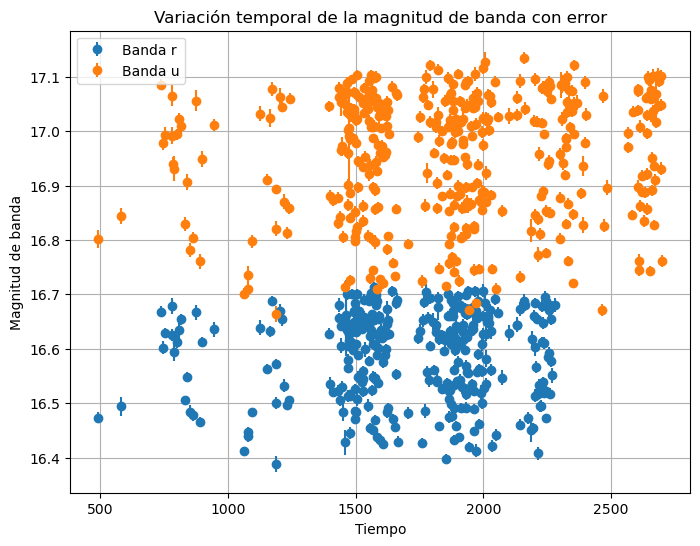

In [3]:
import matplotlib.pyplot as plt

# Suponiendo que 'Data' es tu DataFrame con las columnas apropiadas: 'time', 'magnitude', 'error', 'band'

# Filtrar datos para una estrella específica (por ejemplo, lm0755l16521)
star_id = 'lm0755l16521'
star_data = Data[Data.index == star_id]

# Filtrar por bandas 'r' y 'u'
star_data_r = star_data[star_data['band'] == 'r']
star_data_u = star_data[star_data['band'] == 'u']

# Graficar para la banda 'r'
plt.figure(figsize=(8, 6))
plt.errorbar(star_data_r['time'], star_data_r['magnitude'], yerr=star_data_r['error'], fmt='o', label='Banda r')

# Graficar para la banda 'u'
plt.errorbar(star_data_u['time'], star_data_u['magnitude'], yerr=star_data_u['error'], fmt='o', label='Banda u')

plt.xlabel('Tiempo')
plt.ylabel('Magnitud de banda')
plt.title('Variación temporal de la magnitud de banda con error')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
star_data

,time,Period,magnitude,error,band,class,subclass
oid,,,,,,,
lm0755l16521,493.71633,0.906257,16.473,0.010,r,CEPH,1O_2O
lm0755l16521,583.54354,0.906257,16.494,0.017,r,CEPH,1O_2O
lm0755l16521,739.71497,0.906257,16.668,0.010,r,CEPH,1O_2O
lm0755l16521,746.80231,0.906257,16.602,0.012,r,CEPH,1O_2O
lm0755l16521,752.74176,0.906257,16.629,0.010,r,CEPH,1O_2O
...,...,...,...,...,...,...,...
lm0755l16521,2685.64723,0.906257,17.092,0.011,u,CEPH,1O_2O
lm0755l16521,2693.65211,0.906257,17.102,0.010,u,CEPH,1O_2O
lm0755l16521,2696.65064,0.906257,17.048,0.011,u,CEPH,1O_2O


In [10]:
import numpy as np

def period_fold(times, measurements, errors, p):
    folded_times = (times % p) / p
    inds = np.argsort(folded_times)
    folded_times = folded_times[inds]
    measurements = measurements[inds]
    errors = errors[inds]
    return folded_times, measurements, errors

# Ejemplo de uso
times = np.array([493.71633, 583.54354, 739.71497, 746.80231])
measurements = np.array([16.473, 16.494, 16.668, 16.602])
errors = np.array([0.010, 0.017, 0.010, 0.012])
period = 0.906257

folded_times, folded_measurements, folded_errors = period_fold(times, measurements, errors, period * 2)

print("Folded Times:", folded_times)
print("Folded Measurements:", folded_measurements)
print("Folded Errors:", folded_errors)

Folded Times: [0.02567815 0.1154518  0.39311255 0.95256975]
Folded Measurements: [16.602 16.668 16.473 16.494]
Folded Errors: [0.012 0.01  0.01  0.017]


In [33]:
import numpy as np
import pandas as pd
from statsmodels.nonparametric.kernel_regression import KernelReg

def period_fold_dataframe(df):
    def period_fold(times, periods, measurements, errors):
        p = periods.iloc[0]
        times = (times % p) / p
        inds = np.argsort(times)
        times = times.iloc[inds]
        measurements = measurements.iloc[inds]
        errors = errors.iloc[inds]
        return times, measurements, errors

    def kernel_interpolation(times, measurements, errors):
        try:
            model_measurements = KernelReg(measurements, times, var_type='c')
            interpolated_measurements, _ = model_measurements.fit(times)

            model_errors = KernelReg(errors, times, var_type='c')
            interpolated_errors, _ = model_errors.fit(times)

            return interpolated_measurements, interpolated_errors
        except Exception as e:
            return None, None

    processed_dfs = []
    grouped = df.groupby(level='oid')
    for name, group in grouped:
        print(f"Procesando la estrella '{name}'...")
        folded_periods = period_fold(group['time'], group['Period'], group['magnitude'], group['error'])
        interpolated_measurements, interpolated_errors = kernel_interpolation(
            folded_periods[0], folded_periods[1], folded_periods[2]
        )

        if interpolated_measurements is not None and interpolated_errors is not None:
            folded_df = pd.DataFrame({
                'time': folded_periods[0],
                'Period': group['Period'].iloc[0],
                'magnitude': interpolated_measurements,
                'error': interpolated_errors,
                'band': group['band'],
                'class': group['class'].iloc[0],
                'subclass': group['subclass'].iloc[0],
            })
            processed_dfs.append(folded_df)

    final_df = pd.concat(processed_dfs, ignore_index=False)
    return final_df

Data


,time,Period,magnitude,error,band,class,subclass
oid,,,,,,,
lm0010k11782,294.91026,0.819635,16.700,0.032,r,CEPH,1O
lm0010k11782,296.91696,0.819635,16.824,0.045,r,CEPH,1O
lm0010k11782,301.92747,0.819635,16.854,0.045,r,CEPH,1O
lm0010k11782,315.89025,0.819635,16.882,0.043,r,CEPH,1O
lm0010k11782,317.82385,0.819635,16.723,0.043,r,CEPH,1O
...,...,...,...,...,...,...,...
lm0750n15497,2682.64361,0.387339,20.144,0.163,u,RRL,RRe
lm0750n15497,2682.77791,0.387339,20.506,0.222,u,RRL,RRe
lm0750n15497,2693.65211,0.387339,20.695,0.161,u,RRL,RRe


In [34]:
star_data2 = period_fold_dataframe(star_data)

Procesando la estrella 'lm0755l16521'...


In [35]:
star_data2

,time,Period,magnitude,error,band,class,subclass
oid,,,,,,,
lm0755l16521,0.001462,0.906257,16.765166,0.010529,r,CEPH,1O_2O
lm0755l16521,0.001462,0.906257,16.765166,0.010529,r,CEPH,1O_2O
lm0755l16521,0.001706,0.906257,16.765315,0.010531,r,CEPH,1O_2O
lm0755l16521,0.001706,0.906257,16.765315,0.010531,r,CEPH,1O_2O
lm0755l16521,0.004770,0.906257,16.767181,0.010563,r,CEPH,1O_2O
...,...,...,...,...,...,...,...
lm0755l16521,0.993795,0.906257,16.730507,0.010464,u,CEPH,1O_2O
lm0755l16521,0.995879,0.906257,16.731311,0.010463,u,CEPH,1O_2O
lm0755l16521,0.995879,0.906257,16.731311,0.010463,u,CEPH,1O_2O


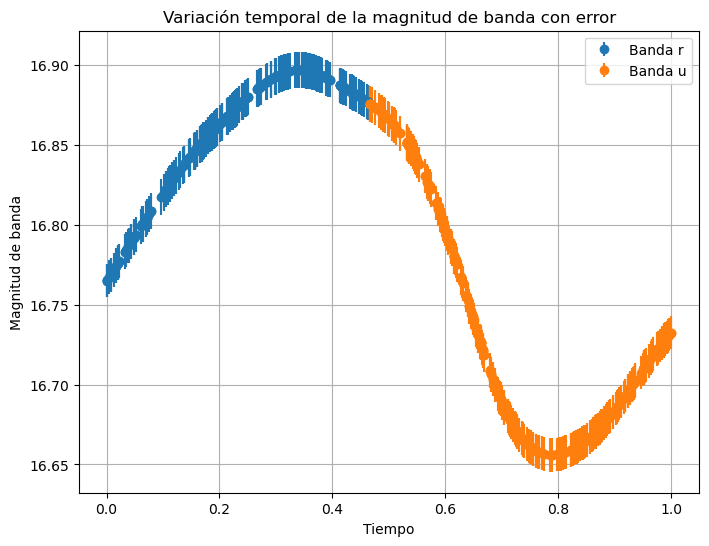

In [36]:
import matplotlib.pyplot as plt

# Suponiendo que 'Data' es tu DataFrame con las columnas apropiadas: 'time', 'magnitude', 'error', 'band'

# Filtrar datos para una estrella específica (por ejemplo, lm0755l16521)
star_id = 'lm0755l16521'

# Filtrar por bandas 'r' y 'u'
star_data_r = star_data2[star_data2['band'] == 'r']
star_data_u = star_data2[star_data2['band'] == 'u']

# Graficar para la banda 'r'
plt.figure(figsize=(8, 6))
plt.errorbar(star_data_r['time'], star_data_r['magnitude'], yerr=star_data_r['error'], fmt='o', label='Banda r')

# Graficar para la banda 'u'
plt.errorbar(star_data_u['time'], star_data_u['magnitude'], yerr=star_data_u['error'], fmt='o', label='Banda u')
plt.xlabel('Tiempo')
plt.ylabel('Magnitud de banda')
plt.title('Variación temporal de la magnitud de banda con error')

plt.legend()
plt.grid(True)
plt.show()

In [80]:
star_ids = ['lm0755l16521', 'lm0750n15497']
selected_stars_data = Data.loc[Data.index.isin(star_ids)]

selected_stars_data = period_fold_dataframe(selected_stars_data)
selected_stars_data 


,time,Period,magnitude,error,band,class,subclass
oid,,,,,,,
lm0750n15497,0.002711,0.387339,20.419887,0.412730,r,RRL,RRe
lm0750n15497,0.002966,0.387339,20.420343,0.412810,r,RRL,RRe
lm0750n15497,0.002966,0.387339,20.420343,0.412810,r,RRL,RRe
lm0750n15497,0.003692,0.387339,20.421635,0.413034,r,RRL,RRe
lm0750n15497,0.003692,0.387339,20.421635,0.413034,r,RRL,RRe
...,...,...,...,...,...,...,...
lm0755l16521,0.993795,0.906257,16.730507,0.010464,u,CEPH,1O_2O
lm0755l16521,0.995879,0.906257,16.731311,0.010463,u,CEPH,1O_2O
lm0755l16521,0.995879,0.906257,16.731311,0.010463,u,CEPH,1O_2O


In [84]:
star_id= 'lm0750n15497'
star_data3 = [selected_stars_data.index == star_id]
# Filtrar por bandas 'r' y 'u'
# Filtrar por bandas 'r' y 'u'
star_data_r = star_data3[star_data3['band'] == r]
star_data_u = star_data3[star_data3['band'] == u]

# Graficar para la banda 'r'
plt.figure(figsize=(8, 6))
plt.errorbar(star_data_r['time'], star_data_r['magnitude'], yerr=star_data_r['error'], fmt='o', label='Banda r - Estrella {}'.format(star_id))

# Graficar para la banda 'u'
plt.errorbar(star_data_u['time'], star_data_u['magnitude'], yerr=star_data_u['error'], fmt='o', label='Banda u - Estrella {}'.format(star_id))

plt.xlabel('Tiempo')
plt.ylabel('Magnitud de banda')
plt.title('Variación temporal de la magnitud de banda con error para la estrella {}'.format(star_id))

plt.legend()
plt.grid(True)
plt.show()

TypeError: list indices must be integers or slices, not str

Ahora aplicaremos este codigo a todo el dataframe 

In [ ]:
Data_Final_Pleg = period_fold_dataframe(Data_Final)
Data_Final_Pleg